Aluno: Gabriel Freitas Santos
MEC 2014

0 - Desenvolvimento do Modelo AR do trabalho anterior

In [1]:
import pandas as pd
import scipy.io as sio
import numpy as np
from os import getcwd,pardir
from os.path import join ,abspath
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.tsa import ar_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from scipy import stats
from scipy.stats.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
fname = join(abspath(join(getcwd(), pardir))+'\\02_feature','data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar
FeatAR = []
na=30 #Model Order
for i in range(Nc):
    ARmodel2 = ar_model.AutoReg(Ch2[:,i],na).fit()
    ARmodel3 = ar_model.AutoReg(Ch3[:,i],na).fit()
    ARmodel4 = ar_model.AutoReg(Ch4[:,i],na).fit()
    ARmodel5 = ar_model.AutoReg(Ch5[:,i],na).fit()
    ARparams = np.concatenate([ARmodel2.params,ARmodel3.params,ARmodel4.params,ARmodel5.params])
    FeatAR.append(ARparams)
FeatAR=np.array(FeatAR)
FeatAR.shape # X1
ln,cols = FeatAR.shape
#Montar metodo de normalização
dfAR = pd.concat([pd.DataFrame(FeatAR),pd.DataFrame({'target':y})],axis=1) 

01 - Design of Hyperparameter search:

Testing 3 different models: softamax, SVM and KNN

In [3]:
models = []
models.append(("LRG",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("KNN",KNeighborsClassifier()))
models

[('LRG', LogisticRegression()),
 ('SVC', SVC()),
 ('KNN', KNeighborsClassifier())]

Define parameters to be tested:

In [16]:
param_grids =[]
param_grids.append( #Softmax
    
        {
            "LRG__C":[1, 10, 20, 60, 70, 100],
            "LRG__solver" :[ 'lbfgs', 'liblinear', 'sag'],
            "LRG__multi_class":['multinomial']  
        }
    
)
param_grids.append( #SVC
    
        {
            "SVC__C"      : stats.loguniform(1e-1,1e3),
            "SVC__kernel" : ['linear','poly','rbf','sigmoid'],
            "SVC__degree" : stats.randint(2,5),
            "SVC__gamma"  : stats.loguniform(1e-4,1e0),
            #"SVC__epsilon"  : stats.loguniform(1e-4,1e1)
        }
    
)
param_grids.append( #KNN
    
        {
            "KNN__n_neighbors" : stats.randint(2,100),
            "KNN__weights"      : ["uniform","distance"],
            "KNN__algorithm" : [ "ball_tree", "kd_tree", "brute"],
            "KNN__leaf_size" : stats.randint(1,30)            
        }
    
)

Get results for default parameters from each model

In [20]:
kfolds = 5
nkiter = 50
n_iter = 100
acc=[]
cfmx =[]
best_params =[]
for i,md in enumerate(models):
    print(f'Iteração {i+1} - {md}\n')
    #Separar Data set em conjuntos de treino e teste ()
    train_x, test_x, train_y, test_y = train_test_split(dfAR[dfAR.columns[0:-1]], dfAR.target, test_size=0.4, random_state=i)

    rkf = RepeatedKFold(n_splits=kfolds,n_repeats=nkiter,random_state=i)

    clf = Pipeline([("scaler",StandardScaler()),(md)])

    param_grid = param_grids[i]

    #Cria modelo
    rnd_model = RandomizedSearchCV(clf,verbose=0,n_iter=n_iter,n_jobs=6,cv=rkf,
                                    random_state=1,param_distributions=param_grid,scoring=accuracy_score)
    rnd_model.fit(train_x,train_y)
    best_params.append(rnd_model.best_params_)
    yh_teste = rnd_model.predict(test_x)
    acc.append(accuracy_score(test_y, yh_teste,normalize=True))
    cfmx.append(confusion_matrix(test_y, yh_teste))
    print(f'Resultados: Acurácia={acc[i]}')
    print(f'Beste Params: {best_params[i]}\n')
   

Iteração 1 - ('LRG', LogisticRegression())

Resultados: Acurácia=0.9970588235294118
Beste Params: {'LRG__solver': 'lbfgs', 'LRG__multi_class': 'multinomial', 'LRG__C': 1}

Iteração 2 - ('SVC', SVC())

Resultados: Acurácia=0.9970588235294118
Beste Params: {'SVC__C': 4.656804637919565, 'SVC__degree': 2, 'SVC__gamma': 0.5373155847046793, 'SVC__kernel': 'poly'}

Iteração 3 - ('KNN', KNeighborsClassifier())

Resultados: Acurácia=0.9852941176470589
Beste Params: {'KNN__algorithm': 'kd_tree', 'KNN__leaf_size': 12, 'KNN__n_neighbors': 14, 'KNN__weights': 'uniform'}



Confusion Matrix Comparing

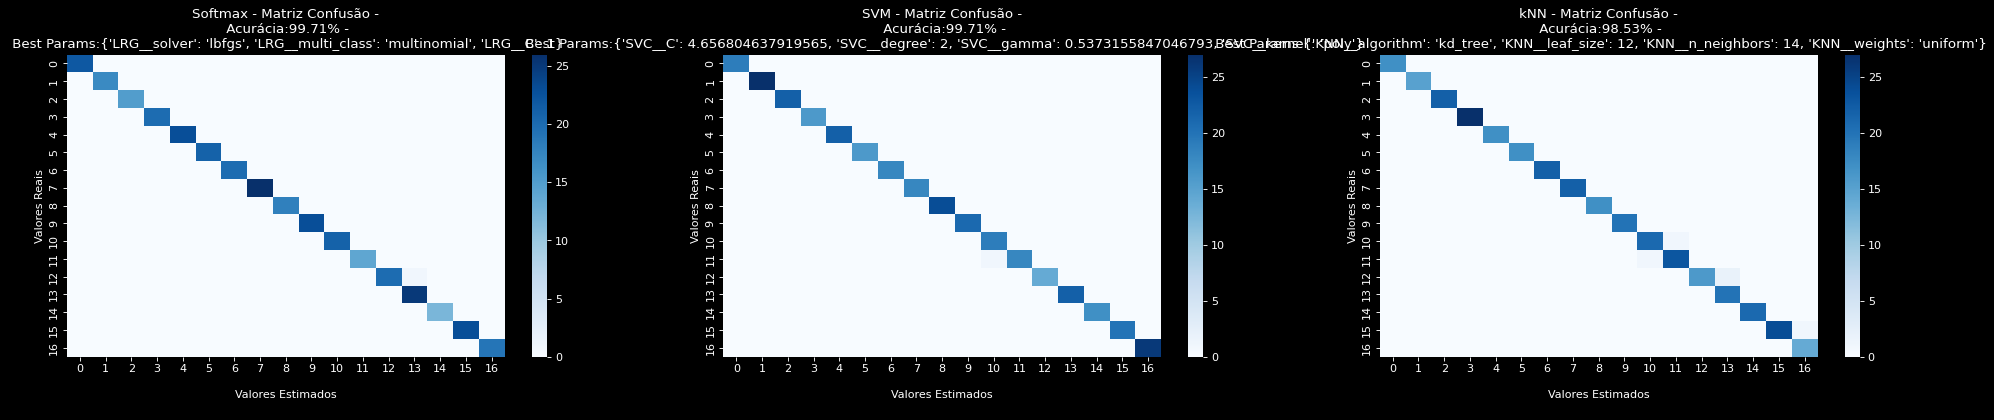

In [21]:
plt.figure(figsize=(30, 5), dpi=80)
plt.subplot(131)
ax0 = sns.heatmap(cfmx[0],  cmap='Blues')
ax0.set_title(f'Softmax - Matriz Confusão -\n Acurácia:{round(100*acc[0],2)}% -\n Best Params:{best_params[0]}')
ax0.set_xlabel('\nValores Estimados\n')
ax0.set_ylabel('Valores Reais')

plt.subplot(132)
ax1 = sns.heatmap(cfmx[1],  cmap='Blues')
ax1.set_title(f'SVM - Matriz Confusão -\n Acurácia:{round(100*acc[1],2)}% -\n Best Params:{best_params[1]}')
ax1.set_xlabel('\nValores Estimados\n')
ax1.set_ylabel('Valores Reais')

plt.subplot(133)
ax2 = sns.heatmap(cfmx[2],  cmap='Blues')
ax2.set_title(f'kNN - Matriz Confusão -\n Acurácia:{round(100*acc[2],2)}% -\n Best Params:{best_params[2]}')
ax2.set_xlabel('\nValores Estimados\n')
ax2.set_ylabel('Valores Reais')
plt.show()
